In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score


##### Check cuda is available

In [2]:

print(torch.cuda.current_device())    # The ID of the current GPU.
print(torch.cuda.get_device_name(id))  # The name of the specified GPU, where id is an integer.
print(torch.cuda.device(id))           # The memory address of the specified GPU, where id is an integer.
print(torch.cuda.device_count())       # The amount of GPUs that are accessible.
  

0
NVIDIA GeForce MX130
1


##### Parameters:

In [3]:

epochs=35
batch_size=32

input=3
layer=[32, 64, 128]
classes=4

train_images_path = 'SportBalls\Train\images'
test_images_path = 'SportBalls\Test\images'
labels_path='SportBalls\Train\labels.csv'

##### Lables:
- 0: baseball;
- 1: basketball;
- 2: volleyball;
- 3: soccerball.

##### Create training, test and validation datasets (split train dataset in train and val datasets to get an accuracy)

In [4]:

# Load labels without column names and specify them
column_names = ['img_name', 'label_ball_1', 'label_ball_2']
labels_df = pd.read_csv(labels_path, header=None, names=column_names)

# Print the first few rows and columns of the DataFrame
print(labels_df.head())
print(labels_df.columns)

# Create binary labels for multi-label classification
def create_binary_labels(df):
    df['label_baseball'] = df.apply(lambda x: 1 if x['label_ball_1'] == 0 or x['label_ball_2'] == 0 else 0, axis=1)
    df['label_basketball'] = df.apply(lambda x: 1 if x['label_ball_1'] == 1 or x['label_ball_2'] == 1 else 0, axis=1)
    df['label_volleyball'] = df.apply(lambda x: 1 if x['label_ball_1'] == 2 or x['label_ball_2'] == 2 else 0, axis=1)
    df['label_soccerball'] = df.apply(lambda x: 1 if x['label_ball_1'] == 3 or x['label_ball_2'] == 3 else 0, axis=1)
    return df

labels_df = create_binary_labels(labels_df)

class CreateDatasets(Dataset):
    def __init__(self, img_dir, labels_df=None, transform=None):
        self.img_dir = img_dir
        self.labels_df = labels_df
        self.transform = transform
        self.img_names = sorted(os.listdir(img_dir))
        if labels_df is not None:
            self.labels = labels_df[['label_baseball', 'label_basketball', 'label_volleyball', 'label_soccerball']].values

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        if self.labels_df is not None:
            labels = self.labels[idx]
            return image, torch.tensor(labels, dtype=torch.float32)
        else:
            return image, self.img_names[idx]
        

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


full_dataset = CreateDatasets(train_images_path, labels_df, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = CreateDatasets(test_images_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    img_name  label_ball_1  label_ball_2
0  img_00000             2             3
1  img_00001             2             2
2  img_00002             1             0
3  img_00003             0             0
4  img_00004             2             2
Index(['img_name', 'label_ball_1', 'label_ball_2'], dtype='object')


##### Display random image with corresponding lables from train dataset (just to check the dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


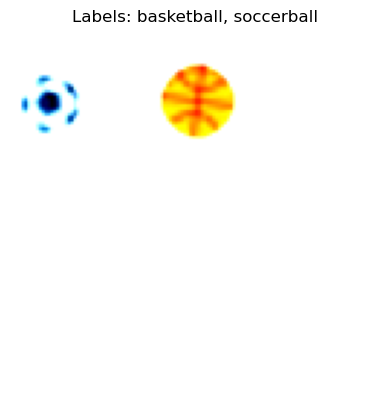

In [5]:

def displayImage():
    idx = random.randint(0, len(train_dataset) - 1)
    image, labels = train_dataset[idx]
    image = image.permute(1, 2, 0).numpy()
    label_names = ['baseball', 'basketball', 'volleyball', 'soccerball']
    label_str = ', '.join([label_names[i] for i, label in enumerate(labels) if label == 1])
    
    plt.imshow(image)
    plt.title(f'Labels: {label_str}')
    plt.axis('off')
    plt.show()

displayImage()


##### Define the model: conv, relu, linear, pool


In [6]:

class Model(nn.Module):
    def __init__(self, input, layer, classes):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(input, layer[0], kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(layer[0], layer[1], kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(layer[1] * layer[0] * layer[0], layer[2])
        self.fc2 = nn.Linear(layer[2], classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, layer[1] * layer[0] * layer[0])
        x = self.dropout(self.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))                          # Using sigmoid since we need binary output for each class
        return x



In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(input, layer, classes).to(device)

print(device)
model



cuda


Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

##### Training Loop

In [8]:
  
def train (model, trainloader, optimizer):
    
    for e in range(epochs):
        tot_train_loss = 0 
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            loss = loss_func(log_ps, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            tot_train_loss += loss.item()
           
        # else:
        #     # Turn off gradients for validation to save memory and speed up computations
        #     with torch.no_grad():
        #         model.eval()
        #         correct = 0
        #         total = 0
        #         with torch.no_grad():
        #             for i, (images, labels) in enumerate(trainloader):
        #                 if i == 10: break
        #                 images, labels = images.to('cuda'), labels.to('cuda')
        #                 outputs = model(images)
        #                 predicted = (outputs > 0.5).float()
        #                 total += labels.size(0) * labels.size(1)
        #                 correct += (predicted == labels).sum().item()
        #     model.train()
               
        #     train_loss = tot_train_loss / len(trainloader.dataset)
        #     accuracy = 100 * correct / total
          
            
            # print("Epoch: {}/{}.. ".format(e+1, epochs),
            # "Loss {:.3f}.. ".format(train_loss),
            # "Accuracy {:.3f}".format(accuracy))
        print(f'Epoch [{e+1}/{epochs}], Loss: {loss.item():.4f}')


# # Define loss function and optimizers
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
train(model, train_loader, optimizer)

Epoch [1/35], Loss: 1.9023
Epoch [2/35], Loss: 1.6632
Epoch [3/35], Loss: 1.6415
Epoch [4/35], Loss: 1.6867
Epoch [5/35], Loss: 1.5504
Epoch [6/35], Loss: 1.6023
Epoch [7/35], Loss: 1.7118
Epoch [8/35], Loss: 1.7880
Epoch [9/35], Loss: 1.7286
Epoch [10/35], Loss: 1.7363
Epoch [11/35], Loss: 1.7113
Epoch [12/35], Loss: 1.7556
Epoch [13/35], Loss: 1.7355
Epoch [14/35], Loss: 1.7751
Epoch [15/35], Loss: 1.7757
Epoch [16/35], Loss: 1.6167
Epoch [17/35], Loss: 1.6390
Epoch [18/35], Loss: 1.8146
Epoch [19/35], Loss: 1.8586
Epoch [20/35], Loss: 1.7134
Epoch [21/35], Loss: 1.8425
Epoch [22/35], Loss: 1.5724
Epoch [23/35], Loss: 1.7168
Epoch [24/35], Loss: 1.7354
Epoch [25/35], Loss: 1.7986
Epoch [26/35], Loss: 1.6463
Epoch [27/35], Loss: 1.9529
Epoch [28/35], Loss: 1.7895
Epoch [29/35], Loss: 1.7352
Epoch [30/35], Loss: 1.6956
Epoch [31/35], Loss: 1.7895
Epoch [32/35], Loss: 1.8542
Epoch [33/35], Loss: 1.7897
Epoch [34/35], Loss: 1.8938
Epoch [35/35], Loss: 1.6955


##### Evaluation: Estimating the model's accuracy: 
- Estimating each classes accuracy and overall model's accuracy.
- Creating csv file for accuracy

In [10]:
def evaluateModel(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5        # choose classes only where sigmoid (prediction) > 0.5
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    val_loss = running_loss / len(val_loader.dataset)
    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)
    
    accuracies = {}
    for i in range(4):
        accuracies[i] = accuracy_score(all_labels[:, i], all_preds[:, i])

    overall_accuracy = np.mean(list(accuracies.values()))
    
    return val_loss, accuracies, overall_accuracy



# Evaluate model on validation set
val_loss, accuracies, overall_accuracy = evaluateModel(model, val_loader, loss_func)
print(f'Validation Loss: {val_loss:.4f}')
with open('accuracy.csv', 'w') as f:
    for label, acc in accuracies.items():
        print(f'Accuracy for label {label}: {acc:.4f}')
        f.write(f'{label},{acc:.4f}\n')
    
    print(f'Overall Accuracy: {overall_accuracy:.4f}')
    f.write(f'All,{overall_accuracy:.4f}\n')




Validation Loss: 0.0537
Accuracy for label 0: 0.9805
Accuracy for label 1: 0.9870
Accuracy for label 2: 0.9910
Accuracy for label 3: 0.9925
Overall Accuracy: 0.9878


##### Generating predictions for the test data and creating csv file for predictions

In [11]:

test_predictions = []
test_image_names = []

model.eval()
with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).int().cpu().numpy()     
        test_predictions.extend(predicted)
        test_image_names.extend(img_names)

# Save predictions to CSV
preds_df = pd.DataFrame(test_predictions, columns=['baseball', 'basketball', 'volleyball', 'soccerball'])
preds_df.insert(0, 'img_name', test_image_names)
preds_df.to_csv('preds.csv', index=False)

# OUTPUTS:
Final accuracy for 35 epochs:
- Accuracy for label 0: 0.9805
- Accuracy for label 1: 0.9870
- Accuracy for label 2: 0.9910
- Accuracy for label 3: 0.9925
- Overall Accuracy: 0.9878

I tried different hyperparameters (like parameters for cnn model, batch size and epochs).
I compared all parameters with 3 and 10 epochs. 

For example, using batch size = 64 I got overall accuracy less than 70%. For batch size = 32 and epochs = 10 I got next accuracy:
- 0, 0.7660;
- 1, 0.9810;
- 2, 0.7960;
- 3, 0.9755;
- All, 0.8796.

By increasing numbers of epochs to 35 I got accuracy more than 98%.